# Exploratory Data Analysis

## 0. Dataset Description
*Taken from dataset [Kaggle page](https://www.kaggle.com/competitions/asl-signs/data)*

Deaf children are often born to hearing parents who do not know sign language. Your challenge in this competition is to help identify signs made in processed videos, which will support the development of mobile apps to help teach parents sign language so they can communicate with their Deaf children.

### 0.1. Files
`train_landmark_files/[participant_id]/[sequence_id].parquet` 

The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

- frame - The frame number in the raw video.
- row_id - A unique identifier for the row.
- type - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- landmark_index - The landmark index number. Details of the hand landmark locations can be found here.
- [x/y/z] - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

`train.csv`
- path - The path to the landmark file.
- participant_id - A unique identifier for the data contributor.
- sequence_id - A unique identifier for the landmark sequence.
- sign - The label for the landmark sequence.

## 1. Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = "../input/asl-signs/"

# Read in train dataset

df = pd.read_csv(f"{BASE_DIR}/train.csv")

## 2. Dataset Information

In [3]:
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [4]:
df.shape

(94477, 4)

`train.csv` has 4 features: the path to each parquet file, the corresponding participant's id, the sequence id, and the sign. Contains 94477 entries.

In [5]:
df["sign"].value_counts()

sign
listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: count, Length: 250, dtype: int64

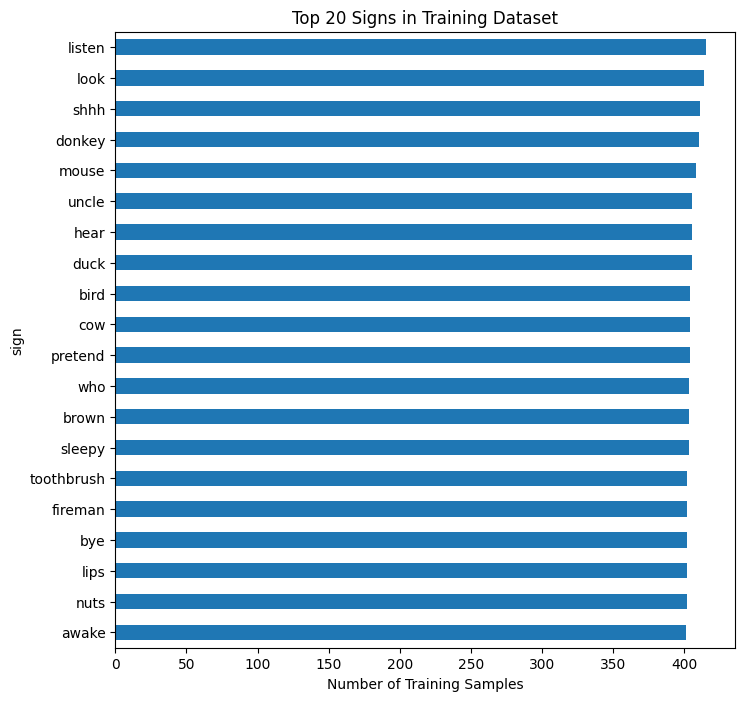

In [6]:
top_k = 20 # How many signs to plot 
fig, ax = plt.subplots(figsize=(8, 8))
df["sign"].value_counts().head(top_k).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title=f"Top {top_k} Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Samples")
plt.show()

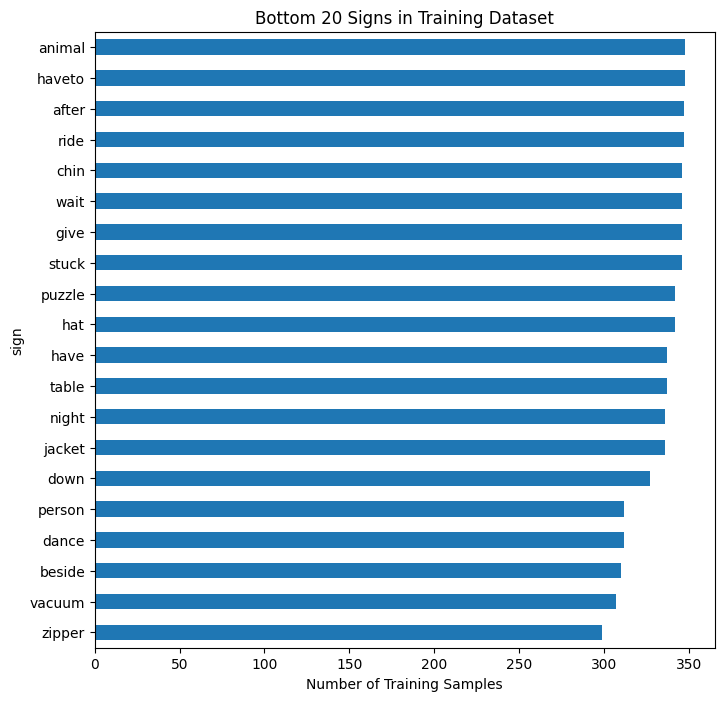

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
df["sign"].value_counts().tail(top_k).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title=f"Bottom {top_k} Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Samples")
plt.show()

Recall that the Parquet files are stored in the `train_landmark_files` directory. Each entry in `train.csv` contains the path to a specific Parquet file.

In [24]:
# Get the path to a Parquet file that has the "cow" sign
target_sign = "cow"
example_parquet_path = df.query(f"sign == '{target_sign}'")["path"].values[0]
example_parquet_path

'train_landmark_files/36257/1021205595.parquet'

We can load the parquet file into a `Dataframe` to get the landmark information.

In [25]:
landmark_df = pd.read_parquet(f"{BASE_DIR}/{example_parquet_path}")
landmark_df.head()

,frame,row_id,type,landmark_index,x,y,z
0,1,1-face-0,face,0,0.476809,0.456741,-0.042842
1,1,1-face-1,face,1,0.469517,0.416260,-0.068233
2,1,1-face-2,face,2,0.471521,0.429064,-0.038716
3,1,1-face-3,face,3,0.453238,0.387312,-0.047121
4,1,1-face-4,face,4,0.467671,0.406001,-0.071225


In [26]:
example_landmark = landmark_df
unique_frames = example_landmark["frame"].nunique()
unique_types = example_landmark["type"].nunique()
types_in_video = example_landmark["type"].unique()
print(
    f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
)

The file has 48 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']


In [27]:
landmark_df["frame"].value_counts().sort_index()

frame
1     543
2     543
3     543
4     543
5     543
6     543
7     543
8     543
9     543
10    543
11    543
12    543
13    543
14    543
15    543
16    543
17    543
18    543
19    543
20    543
21    543
22    543
23    543
24    543
25    543
26    543
27    543
28    543
29    543
30    543
31    543
32    543
33    543
34    543
35    543
36    543
37    543
38    543
39    543
40    543
41    543
42    543
43    543
44    543
45    543
46    543
47    543
48    543
Name: count, dtype: int64

## 3. WIP - 1D CNN preprocessing

In [69]:
import torch
import torch.nn as nn
import gc
import os
import torch.cuda.amp as amp
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
import time

In [13]:
import torch

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("Using CPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
Using device: Tesla T4


In [29]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [30]:
def seed_everything(seed=42):
    # Set PYTHONHASHSEED for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Set random seed for Python's random module
    random.seed(seed)
    
    # Set random seed for numpy
    np.random.seed(seed)
    
    # Set random seed for PyTorch (both CPU and GPU)
    torch.manual_seed(seed)
    
    # For GPU support
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)  # for all devices (GPUs)
    
    # Ensure deterministic behavior for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [31]:
def get_pytorch_dataset(df, batch_size=64, max_len=384, transform=None, gcs=False):
    """
    Creates a PyTorch DataLoader from a DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing file paths and labels.
        batch_size (int): Batch size for loading data.
        transform (callable, optional): Optional transformation to apply on the data.
        gcs (bool): Whether to read files from GCS (True) or local file system (False).
    
    Returns:
        DataLoader: A DataLoader that can be used for training/testing.
    """
    dataset = SignLanguageDataset(df=df, max_len=max_len, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

print(NUM_NODES)
print(CHANNELS)

def interp1d_(x, target_len, method='random'):
    """Interpolates the input tensor to a target length."""
    length = x.shape[1]
    target_len = max(1, target_len)
    
    if method == 'random':
        # Randomly choose one of the interpolation methods
        rand_val = torch.rand(())
        if rand_val < 0.33:
            method = 'bilinear'
        else:
            method = 'bicubic' if torch.rand(()) < 0.5 else 'nearest'
    
    # Resize the tensor using the chosen method
    x = F.interpolate(x, size=(target_len, x.shape[2]), mode=method, align_corners=False)
    return x

def torch_nan_mean(x, dim=0, keepdim=False):
    """Calculates mean, ignoring NaNs."""
    mask = ~torch.isnan(x)
    x = torch.where(mask, x, torch.zeros_like(x))
    count = mask.sum(dim=dim, keepdim=keepdim).clamp(min=1)  # Avoid division by zero
    return x.sum(dim=dim, keepdim=keepdim) / count

def torch_nan_std(x, center=None, dim=0, keepdim=False):
    """Calculates standard deviation, ignoring NaNs."""
    if center is None:
        center = torch_nan_mean(x, dim=dim, keepdim=True)
    d = x - center
    variance = torch_nan_mean(d * d, dim=dim, keepdim=keepdim)
    return torch.sqrt(variance)

class Preprocess(nn.Module):
    def __init__(self, max_len=None, point_landmarks=None):
        super(Preprocess, self).__init__()
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def forward(self, inputs):
        # Ensure input is 4D (batch, time, points, channels)
        if inputs.dim() == 3:
            x = inputs.unsqueeze(0)
        else:
            x = inputs

        # Calculate mean over landmarks (axis 2)
        mean = torch_nan_mean(x[:, :, [17], :], dim=(1, 2), keepdim=True)
        mean = torch.where(torch.isnan(mean), torch.tensor(0.5, dtype=x.dtype, device=x.device), mean)

        # Gather the specified landmarks and calculate the standard deviation
        x = x[:, :, self.point_landmarks, :]  # N, T, P, C
        std = torch_nan_std(x, mean, dim=(1, 2), keepdim=True)

        # Normalize the data
        x = (x - mean) / std

        # Trim the sequence to max_len if specified
        if self.max_len is not None:
            x = x[:, :self.max_len]
        length = x.shape[1]

        # Keep only the first two coordinates
        x = x[..., :2]

        # Compute first and second differences
        if x.shape[1] > 1:
            dx = torch.cat([x[:, 1:] - x[:, :-1], torch.zeros_like(x[:, :1])], dim=1)
        else:
            dx = torch.zeros_like(x)

        if x.shape[1] > 2:
            dx2 = torch.cat([x[:, 2:] - x[:, :-2], torch.zeros_like(x[:, :2])], dim=1)
        else:
            dx2 = torch.zeros_like(x)

        # Concatenate the features
        x = torch.cat([
            x.reshape(-1, length, 2 * len(self.point_landmarks)),
            dx.reshape(-1, length, 2 * len(self.point_landmarks)),
            dx2.reshape(-1, length, 2 * len(self.point_landmarks)),
        ], dim=-1)

        # Replace NaNs with zeros
        x = torch.where(torch.isnan(x), torch.tensor(0., dtype=x.dtype, device=x.device), x)

        return x


118
708


In [33]:
# Helper function to replace NaNs with zeroes
def torch_nanmean(x, dim=0, keepdim=False):
    mask = ~torch.isnan(x)
    x = torch.where(mask, x, torch.zeros_like(x))
    count = mask.sum(dim=dim, keepdim=keepdim).clamp(min=1)  # Avoid division by zero
    return x.sum(dim=dim, keepdim=keepdim) / count

# Decode TFRecord equivalent
def decode_torchrec(record_bytes):
    coordinates = record_bytes['coordinates']
    sign = record_bytes['sign']
    out = {
        'coordinates': coordinates.view(-1, ROWS_PER_FRAME, 3),
        'sign': sign
    }
    return out

# Filter NaNs
def filter_nans_torch(x, ref_point=POINT_LANDMARKS):
    # Convert to tensor if input is a NumPy array
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
        
    # Check for NaNs across rows (axis=1) and keep rows that are not all NaN
    mask = ~torch.all(torch.isnan(x), dim=1)
    return x[mask]

# Create a label-to-index mapping (only once)
sign_to_index = {sign: idx for idx, sign in enumerate(df['sign'].unique())}

def preprocess(x, sign, augment=True, max_len=MAX_LEN):
    coord = torch.as_tensor(x, dtype=torch.float32)

    # Replace NaNs with PAD value
    coord = filter_nans_torch(coord)

    # Ensure proper shape: (T, 543, 3)
    total_points = coord.size(0)
    expected_size = ROWS_PER_FRAME * 3

    if total_points % expected_size != 0:
        padding_needed = expected_size - (total_points % expected_size)
        if padding_needed < expected_size:
            pad = torch.full((padding_needed, coord.size(1)), PAD, dtype=torch.float32)
            coord = torch.cat((coord, pad), dim=0)
        else:
            coord = coord[:total_points - (total_points % expected_size)]

    coord = coord.view(-1, ROWS_PER_FRAME, 3)

    # print("Before flip", coord.shape)

    # # Apply flip here
    # coord = coord[:, POINT_LANDMARKS, :]

    # print("After flip", coord.shape)


    # Apply augmentation
    if augment:
        coord = augment_fn(coord, max_len=max_len)

    # Apply padding of zeros
    if coord.shape[0] < max_len:
        pad_len = max_len - coord.shape[0]
        pad = torch.zeros((pad_len, coord.shape[1], coord.shape[2]))
        coord = torch.cat([coord, pad], dim=0)
    else:
        coord = coord[:max_len]

    # print("After padding", coord.shape)


    # Run through preprocessing module
    preprocessor = Preprocess(max_len=max_len, point_landmarks=POINT_LANDMARKS)
    processed = preprocessor(coord.unsqueeze(0)).squeeze(0)  # Output: (max_len, CHANNELS)

    # Convert sign to one-hot label
    sign_index = sign_to_index[sign]
    one_hot_label = F.one_hot(torch.tensor(sign_index), NUM_CLASSES)

    return processed.float(), one_hot_label


# def preprocess(x, sign, augment=False, max_len=MAX_LEN):
#     coord = torch.as_tensor(x, dtype=torch.float32)
#     coord = filter_nans_torch(x)

#     # Check if the size is divisible by the expected number of columns (543 * 3)
#     total_points = coord.size(0)
#     expected_size = ROWS_PER_FRAME * 3

#     # Padding or truncation if necessary
#     if total_points % expected_size != 0:
#         padding_needed = expected_size - (total_points % expected_size)
#         if padding_needed < expected_size:
#             pad = torch.zeros((padding_needed, coord.size(1)), dtype=torch.float32)
    #         coord = torch.cat((coord, pad), dim=0)
    #     else:
    #         coord = coord[:total_points - (total_points % expected_size)]

    # # Reshape the coordinates to (-1, ROWS_PER_FRAME, 3)
    # coord = coord.view(-1, ROWS_PER_FRAME, 3)

    # # Augmentation if required
    # if augment:
    #     coord = augment_fn(coord, max_len=max_len)

    # # Convert sign to an integer label using the mapping
    # sign_index = sign_to_index[sign]

    # return coord.float(), F.one_hot(torch.tensor(sign_index), NUM_CLASSES)

# def preprocess(x, augment=False, max_len=MAX_LEN):
#     coord = x['coordinates']
    
#     # Filter out NaNs (assuming the function is implemented in PyTorch)
    # # coord = filter_nans(coord)
    
    # # # Apply augmentation if specified
    # # if augment:
    # #     coord = augment_fn(coord, max_len=max_len)
    
    # # # Ensure the shape (this can be done with padding or truncation if necessary)
    # # coord = coord.view(-1, ROWS_PER_FRAME, 3)  # Reshape the tensor
    
    # # # Apply the Preprocess transformation (assuming it's implemented for PyTorch)
    # # coord = Preprocess(max_len=max_len)(coord)[0]  # Get the first element if it's a tuple
    
    # # # Convert to float32
    # # coord = coord.float()
    
    # # # Convert the sign to a one-hot encoded tensor
    # # sign = torch.tensor(x['sign'], dtype=torch.long)
    # # target = torch.nn.functional.one_hot(sign, num_classes=NUM_CLASSES).float()
    
    # # return coord, target

# Flip left-right
def flip_lr(x):
    x[..., 0] = 1 - x[..., 0]
    new_x = x.clone()

    # Swap landmarks based on constants
    for l, r in zip([LHAND, LLIP, LPOSE, LEYE, LNOSE], [RHAND, RLIP, RPOSE, REYE, RNOSE]):
        new_x[l], new_x[r] = x[r], x[l]

    return new_x

# Temporal resampling
def resample(x, rate=(0.8, 1.2)):
    rate = torch.FloatTensor(1).uniform_(*rate).item()
    length = x.shape[0]
    new_size = int(rate * length)
    return F.interpolate(x.unsqueeze(0), size=(new_size, x.shape[1]), mode='bilinear', align_corners=False).squeeze(0)

# Spatial random affine transformation, applies randomized scaling, shearing, rotation, and shifting to 2D coordinates
def spatial_random_affine(xyz, scale=(0.8, 1.2), shear=(-0.15, 0.15), shift=(-0.1, 0.1), degree=(-30, 30)):
    center = torch.tensor([0.5, 0.5], dtype=torch.float32)

    if scale:
        scale_factor = torch.FloatTensor(1).uniform_(*scale).item()
        xyz *= scale_factor

    if shear:
        shear_x = shear_y = torch.FloatTensor(1).uniform_(*shear).item()
        if torch.rand(1).item() < 0.5:
            shear_x = 0.0
        else:
            shear_y = 0.0
        shear_mat = torch.tensor([[1., shear_x], [shear_y, 1.]], dtype=torch.float32)
        xy = torch.matmul(xyz[..., :2], shear_mat)
        xyz[..., :2] = xy

    if degree:
        deg = torch.FloatTensor(1).uniform_(*degree).item()
        rad = torch.tensor(deg / 180 * np.pi)
        c, s = torch.cos(rad), torch.sin(rad)
        rotate_mat = torch.tensor([[c, s], [-s, c]], dtype=torch.float32)
        xy = xyz[..., :2] - center
        xy = torch.matmul(xy, rotate_mat) + center
        xyz[..., :2] = xy

    if shift:
        shift_val = torch.FloatTensor(1).uniform_(*shift).item()
        xyz += shift_val

    return xyz

# Temporal crop, cuts out random parts of sequence
def temporal_crop(x, length=MAX_LEN):
    l = x.shape[0]
    offset = torch.randint(0, max(1, l - length + 1), (1,)).item()
    return x[offset:offset + length]

# Temporal mask, masks a continuous chunk of frames over *time*.
def temporal_mask(x, size=(0.2, 0.4), mask_value=0.0):
    l = x.shape[0]
    mask_size = int(torch.FloatTensor(1).uniform_(*size).item() * l)
    mask_offset = torch.randint(0, max(1, l - mask_size + 1), (1,)).item()
    x[mask_offset:mask_offset + mask_size] = mask_value
    return x

# Spatial mask, masks a rectangular spatial *region* within the (x, y) coordinates of the input.
# Like hiding a hand or body part
def spatial_mask(x, size=(0.2, 0.4), mask_value=0.0):
    mask_size = torch.FloatTensor(1).uniform_(*size).item()
    mask_offset_y = torch.rand(1).item()
    mask_offset_x = torch.rand(1).item()
    y_mask = (x[..., 1] > mask_offset_y) & (x[..., 1] < mask_offset_y + mask_size)
    x_mask = (x[..., 0] > mask_offset_x) & (x[..., 0] < mask_offset_x + mask_size)
    mask = y_mask & x_mask
    x[mask] = mask_value
    return x

def augment_fn(x, always=False, max_len=None):
    # if random.random() < 0.5 or always:
    #     x = flip_lr(x)
    #     print("flip applied")
    # if random.random() < 0.8 or always:
    #     x = resample(x, (0.5, 1.5))
    #     print("resample applied", x.shape)
    if max_len is not None:
        x = temporal_crop(x, max_len)
        # print("temporal crop applied", x.shape)
    if random.random() < 0.75 or always:
        x = spatial_random_affine(x)
        # print("spatial random affine applied", x.shape)
    if random.random() < 0.5 or always:
        x = temporal_mask(x)
        # print("temporal mask applied", x.shape)
    if random.random() < 0.5 or always:
        x = spatial_mask(x)
        # print("spatial mask applied", x.shape)
    return x

In [67]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import pyarrow.parquet as pq

class SignLanguageDataset(Dataset):
    def __init__(self, df, max_len, transform=None):
        self.data = df
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sample from the DataFrame
        sample = self.data.iloc[idx]

        # Load the Parquet file specified in the 'path' column
        path = f"{BASE_DIR}/{sample['path']}"
        landmark_df = pd.read_parquet(path)

        # Extract coordinates (x, y, z) from the DataFrame
        coordinates = landmark_df[['x', 'y', 'z']].values

        sign = sample['sign']

        # Preprocess the data
        if self.transform:
            # coordinates = self.transform(coordinates, sign)
            coordinates, sign = self.transform(coordinates, sign)
        else:
            coordinates = landmark_df[['x', 'y', 'z']].fillna(0).values
            coordinates = np.asarray(coordinates, dtype=np.float32)
    
            # Pad/truncate to max_len
            if coordinates.shape[0] > self.max_len:
                coordinates = coordinates[:self.max_len]
            elif coordinates.shape[0] < self.max_len:
                pad_len = self.max_len - coordinates.shape[0]
                padding = np.zeros((pad_len, 3), dtype=np.float32)
                coordinates = np.vstack((coordinates, padding))

        # Convert the sign to a numeric label if necessary
        # Assuming you have a label-to-index mapping
        sign = sample['sign']
        if isinstance(sign, str):
            sign = sign_to_index[sign]

        # coordinates = landmark_df[['x', 'y', 'z']].fillna(0).values
        # coordinates = np.asarray(coordinates, dtype=np.float32)
        
        # # Pad/truncate to max_len
        # if coordinates.shape[0] > self.max_len:
        #     coordinates = coordinates[:self.max_len]
        # elif coordinates.shape[0] < self.max_len:
        #     pad_len = self.max_len - coordinates.shape[0]
        #     padding = np.zeros((pad_len, 3), dtype=np.float32)
        #     coordinates = np.vstack((coordinates, padding))
        inputs = torch.tensor(coordinates, dtype=torch.float32)

        # Transposed to fit dimensions
        # inputs = inputs.transpose(0, 1)
        target = torch.tensor(sign, dtype=torch.long)
        return inputs, target

# Example usage!!
dataset = SignLanguageDataset(df=df, max_len=64, transform=preprocess)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

for inputs, targets in data_loader:
    print(inputs.shape, targets.shape)
    print(inputs)
    print("AAAA")
    print(targets)
    break


torch.Size([64, 384, 708]) torch.Size([64])
tensor([[[-0.0143, -0.0136, -0.0143,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0143, -0.0136, -0.0143,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0143, -0.0136, -0.0143,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.0143, -0.0136, -0.0143,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0143, -0.0136, -0.0143,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0143, -0.0136, -0.0143,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1086,  0.1201,  0.1030,  ...,  0.0140, -0.0015,  0.0099],
         [ 0.0896,  0.1020,  0.1073,  ..., -0.0134, -0.0433,  0.1221],
         [ 0.1045,  0.1237,  0.0918,  ..., -0.0186, -0.0116, -0.0034],
         ...,
         [ 0.0617,  0.0613,  0.0617,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0617,  0.0613,  0.0617,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0617,  0.0613,  0.0617,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0970,  0.1287,  0.0844,  ...,  0.0171,  0.0051,  0.0101],
 

## Transformer model

In [59]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim=256, num_heads=4, dropout=0):
        super().__init__()
        self.dim = dim
        self.scale = dim ** -0.5
        self.num_heads = num_heads
        self.qkv = nn.Linear(dim, 3 * dim, bias=False)
        self.drop1 = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim, bias=False)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.dim // self.num_heads)
        q, k, v = qkv.unbind(dim=2)

        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        if mask is not None:
            attn = attn.masked_fill(mask[:, None, None, :].bool(), float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.drop1(attn)

        x = torch.matmul(attn, v).transpose(1, 2).reshape(batch_size, seq_len, self.dim)
        x = self.proj(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation=nn.SiLU()):
        super().__init__()
        self.attn_norm = nn.BatchNorm1d(dim)
        self.attn = MultiHeadSelfAttention(dim=dim, num_heads=num_heads, dropout=attn_dropout)
        self.attn_drop = nn.Dropout(drop_rate)
        self.ffn_norm = nn.BatchNorm1d(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * expand, bias=False),
            activation,
            nn.Linear(dim * expand, dim, bias=False),
            nn.Dropout(drop_rate)
        )

    def forward(self, x):
        attn_out = x + self.attn_drop(self.attn(self.attn_norm(x.transpose(1, 2)).transpose(1, 2)))
        x = attn_out + self.ffn(self.ffn_norm(attn_out.transpose(1, 2)).transpose(1, 2))
        return x


In [60]:
class GetModel(nn.Module):
    def __init__(self, max_len=64, dropout_step=0, dim=192, channels=CHANNELS, num_classes=NUM_CLASSES):
        super(GetModel, self).__init__()
        self.max_len = max_len
        self.channels = channels
        self.dim = dim
        self.num_classes = num_classes
        self.ksize = 17

        # Stem
        self.stem_conv = nn.Linear(channels, dim, bias=False)
        self.stem_bn = nn.BatchNorm1d(max_len, momentum=0.95)

        # Blocks
        self.blocks = nn.Sequential(
            Conv1DBlock(dim, self.ksize, drop_rate=0.2),
            Conv1DBlock(dim, self.ksize, drop_rate=0.2),
            Conv1DBlock(dim, self.ksize, drop_rate=0.2),
            TransformerBlock(dim, expand=2),
            Conv1DBlock(dim, self.ksize, drop_rate=0.2),
            Conv1DBlock(dim, self.ksize, drop_rate=0.2),
            Conv1DBlock(dim, self.ksize, drop_rate=0.2),
            TransformerBlock(dim, expand=2)
        )

        # Additional blocks for the 4x model
        if dim == 384:
            self.extra_blocks = nn.Sequential(
                Conv1DBlock(dim, self.ksize, drop_rate=0.2),
                Conv1DBlock(dim, self.ksize, drop_rate=0.2),
                Conv1DBlock(dim, self.ksize, drop_rate=0.2),
                TransformerBlock(dim, expand=2),
                Conv1DBlock(dim, self.ksize, drop_rate=0.2),
                Conv1DBlock(dim, self.ksize, drop_rate=0.2),
                Conv1DBlock(dim, self.ksize, drop_rate=0.2),
                TransformerBlock(dim, expand=2)
            )
        else:
            self.extra_blocks = None

        # Top layers
        self.top_conv = nn.Linear(dim, dim * 2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.8)
        self.classifier = nn.Linear(dim * 2, num_classes)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.stem_bn(x)
        x = self.blocks(x)

        if self.extra_blocks:
            x = self.extra_blocks(x)

        x = self.top_conv(x)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Instantiate model
# model = GetModel()

# Example forward pass
# temp_train should be a list of inputs, where temp_train[0] is input data and temp_train[1] is the labels
# y = model(torch.tensor(temp_train[0]))
# loss = nn.CrossEntropyLoss()(y, torch.tensor(temp_train[1]))


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score

# Training function
def train_fold(CFG, fold, train_files, valid_files=None, strategy=None, summary=True):
    seed_everything(CFG.seed)
    gc.collect()

    # Set mixed precision
    if CFG.fp16:
        scaler = GradScaler()  # Updated to use GradScaler directly 
    else:
        scaler = None
        
    df = CFG.df
    if fold != 'all':
        train_df = df[df['path'].isin(train_files)].reset_index(drop=True)
        valid_df = df[df['path'].isin(valid_files)].reset_index(drop=True)
        train_ds = get_pytorch_dataset(train_df, CFG.batch_size, CFG.max_len, transform=preprocess)
        valid_ds = get_pytorch_dataset(valid_df, CFG.batch_size, CFG.max_len)
    else:
        train_df = df[df['path'].isin(train_files)].reset_index(drop=True)
        train_ds = get_pytorch_dataset(train_df, CFG.batch_size, CFG.max_len, transform=preprocess)
        valid_ds = None
        valid_files = []

    num_train = len(train_df)  # Use the actual number of samples, not dataset length
    num_valid = len(valid_df) if valid_ds is not None else 0
    
    # Calculate actual steps per epoch correctly
    steps_per_epoch = (num_train + CFG.batch_size - 1) // CFG.batch_size  # Ceiling division
    print(f"Number of training samples: {num_train}, batches: {steps_per_epoch}")
    print(f"Number of validation samples: {num_valid}")
    
    dropout_step = CFG.dropout_start_epoch * steps_per_epoch

    model = GetModel(dim=CFG.dim, max_len=CFG.max_len, dropout_step=CFG.dropout_start_epoch)
    model = model.to(CFG.device)

    # Optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
    
    # Calculate total steps correctly for OneCycleLR
    total_steps = steps_per_epoch * CFG.epoch
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=CFG.lr, 
        total_steps=total_steps,
        pct_start=CFG.warmup
    )

    # Loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    if summary:
        print(f"Training fold {fold}...")
        print(model)
        print(f"Total training steps: {total_steps}")

    # Checkpoint for saving best model
    best_val_loss = float('inf')
    best_val_acc = 0.0
    
    # Training loop
    for epoch in range(CFG.resume, CFG.epoch):
        start_time = time.time()
        print("On epoch number:", epoch + 1, "/", CFG.epoch)
        model.train()
        running_loss = 0.0
        all_preds = []
        all_targets = []
        
        for step, (inputs, targets) in enumerate(train_ds):
            inputs, targets = inputs.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            
            with autocast(enabled=CFG.fp16):  # Updated to use autocast directly
                outputs = model(inputs)
                print(outputs.shape)
                loss = criterion(outputs, targets)
            
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            
            # Calculate accuracy 
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Scheduler step
            scheduler.step()

        # Calculate training metrics
        time_end = time.time()
        print(f"Epoch {epoch+1} took {time_end - start_time} seconds to train")
        epoch_loss = running_loss / len(train_ds)
        epoch_acc = accuracy_score(all_targets, all_preds)
        print(f"Epoch {epoch+1}/{CFG.epoch}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation step
        if valid_ds is not None:
            model.eval()
            val_loss = 0.0
            val_preds = []
            val_targets = []
            
            with torch.no_grad():
                for inputs, targets in valid_ds:
                    inputs, targets = inputs.to(CFG.device), targets.to(CFG.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    
                    # Calculate validation accuracy
                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())
                    
            val_loss /= len(valid_ds)
            val_acc = accuracy_score(val_targets, val_preds)
            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
            
            # Save best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"{CFG.output_dir}/{CFG.comment}-fold{fold}-best-loss.pth")
                
            # Save best model based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"{CFG.output_dir}/{CFG.comment}-fold{fold}-best-acc.pth")
        
        # Save model checkpoint periodically
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"{CFG.output_dir}/{CFG.comment}-fold{fold}-epoch{epoch+1}.pth")
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f"{CFG.output_dir}/{CFG.comment}-fold{fold}-best-loss.pth"))
    
    # Final evaluation
    if valid_ds is not None:
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for inputs, targets in valid_ds:
                inputs, targets = inputs.to(CFG.device), targets.to(CFG.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # Calculate final accuracy
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
                
        val_loss /= len(valid_ds)
        val_acc = accuracy_score(val_targets, val_preds)
        print(f"Final Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    if valid_ds is not None:
        return model, val_loss, val_acc
    else:
        return model, None, None

# Training loop for multiple folds
def train_folds(CFG, folds, strategy=None, summary=True):
    results = []
    for fold in folds:
        if fold != 'all':
            all_files = CFG.df["path"].tolist()  # Fixed to use CFG.df
            train_files, valid_files = train_test_split(all_files, test_size=0.2, random_state=CFG.seed, shuffle=True)
        else:
            train_files = CFG.df["path"]  # Fixed to use CFG.df
            valid_files = None

        model, val_loss, val_acc = train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)
        results.append((fold, val_loss, val_acc))
    
    # Print summary of results
    print("\nTraining Results Summary:")
    for fold, loss, acc in results:
        if acc is not None:
            print(f"Fold {fold}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")
        else:
            print(f"Fold {fold}: Loss = {loss:.4f}")
    
    return results

In [82]:
# Efficient Channel Attention (ECA) Layer
class ECA(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, 
                             padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x is [B, C, L]
        # Take channel attention
        y = self.avg_pool(x)  # [B, C, 1]
        
        # Transpose to use conv1d across channels
        y = y.transpose(1, 2)  # [B, 1, C]
        y = self.conv(y)
        y = self.sigmoid(y)
        y = y.transpose(1, 2)  # [B, C, 1]
        
        # Multiply with input
        return x * y

# LateDropout Layer
class LateDropout(nn.Module):
    def __init__(self, rate, start_step=0):
        super().__init__()
        self.rate = rate
        self.start_step = start_step
        self.train_counter = 0
        self.dropout = nn.Dropout(rate)

    def forward(self, x, training=False):
        if self.train_counter < self.start_step:
            output = x
        else:
            output = self.dropout(x) if training else x
        if training:
            self.train_counter += 1
        return output

class CausalDWConv1D(nn.Module):
    def __init__(self, channels, kernel_size=17, dilation_rate=1, use_bias=False):
        super().__init__()
        self.causal_pad = nn.ConstantPad1d((dilation_rate * (kernel_size - 1), 0), 0)
        self.dw_conv = nn.Conv1d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=kernel_size,
            stride=1,
            dilation=dilation_rate,
            padding=0,
            groups=channels,  # This makes it truly depthwise
            bias=use_bias
        )
        
    def forward(self, x):
        # x should be [B, C, L]
        x = self.causal_pad(x)
        x = self.dw_conv(x)
        return x

class Conv1DBlock(nn.Module):
    def __init__(self, channel_size, kernel_size, dilation_rate=1, drop_rate=0.0, expand_ratio=2, activation=F.silu):
        super().__init__()
        self.channel_size = channel_size
        self.expanded_size = channel_size * expand_ratio
        
        # Layers
        self.norm1 = nn.LayerNorm(channel_size)
        self.expand_conv = nn.Linear(channel_size, self.expanded_size)
        self.norm2 = nn.LayerNorm(self.expanded_size)
        self.dw_conv = CausalDWConv1D(self.expanded_size, kernel_size, dilation_rate)
        self.eca = ECA(kernel_size=5)
        self.project_conv = nn.Linear(self.expanded_size, channel_size)
        self.dropout = nn.Dropout(drop_rate)
        self.activation = activation
        
    def forward(self, x):
        # x is [B, L, C]
        skip = x
        
        # Pre-normalization
        x = self.norm1(x)
        
        # Expansion
        x = self.expand_conv(x)  # [B, L, C*expand]
        x = self.activation(x)
        
        # Depthwise conv requires channels first
        x = x.transpose(1, 2)  # [B, C*expand, L]
        x = self.dw_conv(x)
        
        # Apply ECA
        x = self.eca(x)
        
        # Back to [B, L, C*expand] for projection
        x = x.transpose(1, 2)
        
        # Normalization before projection
        x = self.norm2(x)
        
        # Project back to original dimensionality
        x = self.project_conv(x)  # [B, L, C]
        x = self.dropout(x)
        
        # Residual connection if shapes match
        if x.shape == skip.shape:
            x = x + skip
            
        return x


In [83]:
class CFG:
    n_splits = 5
    df = pd.read_csv(f"{BASE_DIR}/train.csv")
    save_output = True
    output_dir = '.'
    
    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch
    
    max_len = 384
    replicas = 8
    lr = 5e-4 * replicas
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 5 #400
    # warmup needs to be between 0 and 1
    warmup = 0.1
    batch_size = 64 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))
    
    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'
    device = device

In [84]:
train_folds(CFG, [0])

<ipython-input-81-a6d8f428a364>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Updated to use GradScaler directly


Number of training samples: 75581, batches: 148
Number of validation samples: 18896
Training fold 0...
GetModel(
  (stem_conv): Linear(in_features=708, out_features=192, bias=False)
  (stem_bn): BatchNorm1d(384, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Conv1DBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (expand_conv): Linear(in_features=192, out_features=384, bias=True)
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dw_conv): CausalDWConv1D(
        (causal_pad): ConstantPad1d(padding=(16, 0), value=0)
        (dw_conv): Conv1d(384, 384, kernel_size=(17,), stride=(1,), groups=384, bias=False)
      )
      (eca): ECA(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (conv): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (sigmoid): Sigmoid()
      )
      (project_conv): Linear(in_features=384, out_features=192, bias=True)
 

<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([512, 250])


<ipython-input-81-a6d8f428a364>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CFG.fp16):  # Updated to use autocast directly


torch.Size([317, 250])
Epoch 1 took 2005.1590123176575 seconds to train
Epoch 1/5, Loss: nan, Accuracy: 0.0044


RuntimeError: mat1 and mat2 shapes cannot be multiplied (196608x3 and 708x192)